# U.S. Patent Phrase to Phrase Matching

*Help Identify Similar Phrases in U.S. Patents.*

This competition has as goal to apply and experiment **with** the lesson 3 of the FastAI deep learning tutorial's [notebook](https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners).

## Setup

In [ ]:
!mv .kaggle /root/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c us-patent-phrase-to-phrase-matching

100% 682k/682k [00:00<00:00, 852kB/s]
100% 682k/682k [00:00<00:00, 852kB/s]


In [ ]:
!unzip us-patent-phrase-to-phrase-matching.zip

Archive:  us-patent-phrase-to-phrase-matching.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Data exploration

### Data loading and structure

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np

In [ ]:
train = pd.read_csv('./train.csv')

In [ ]:
train.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [ ]:
train.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


<Axes: >

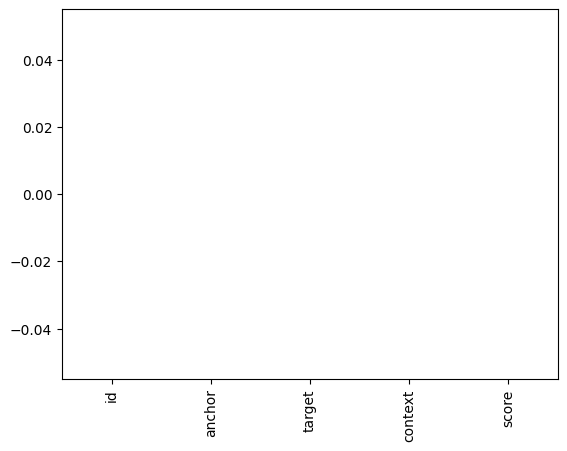

In [ ]:
train.isnull().sum().plot(kind='bar')

There seems to be no null or NaN values in the dataset.



Text(0, 0.5, 'Samples')

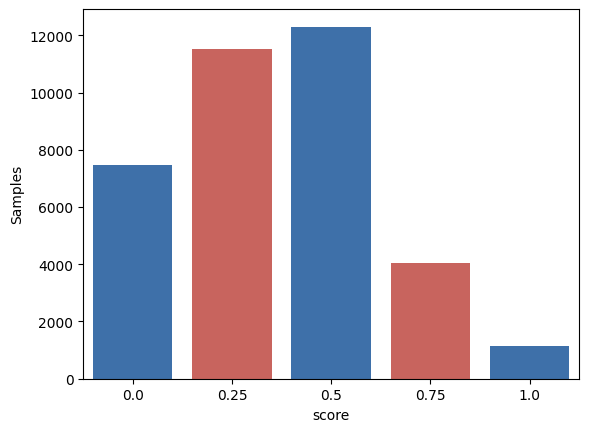

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

color = [sns.xkcd_rgb['medium blue'], sns.xkcd_rgb['pale red']]
sns.countplot(x='score',data = train, palette = color)
plt.gca().set_ylabel('Samples')

Here, we can see that there is a lot less data for the scores 0.75 and especially 1.0.

### Distribution of character, word,  and sentence frequency

In [ ]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize, sent_tokenize

# count number of characters in each tweet
train['char_len'] = train.anchor.str.len()

# count number of words in each tweet
word_tokens = [len(word_tokenize(tweet)) for tweet in train.anchor]
train['word_len'] = word_tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


KeyboardInterrupt: ignored

In [ ]:
# Investigate the Outliers
train['char_len'].describe()

### Plot most common stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Text(0.5, 1.0, 'Top Stopwords in targets')

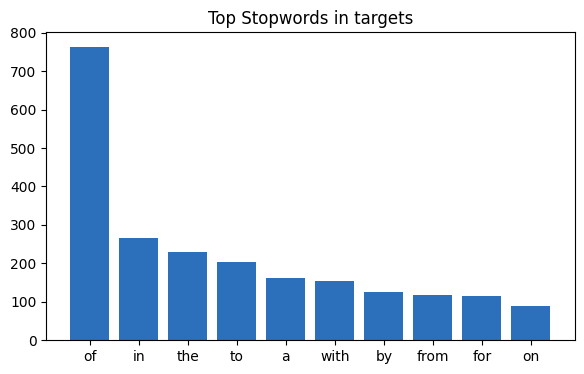

In [ ]:
## Plot most common stopwords
nltk.download('stopwords')

from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

# Get all the word tokens in dataframe
corpus = []
[corpus.append(word.lower()) for elem in train.target for word in word_tokenize(elem)]

# Function for counting top stopwords in a corpus
def count_top_stopwords(corpus):
    stopwords_freq = {}
    for word in corpus:
        if word in stop:
            if word in stopwords_freq:
                stopwords_freq[word] += 1
            else:
                stopwords_freq[word] = 1
    topwords = sorted(stopwords_freq.items(), key=lambda item: item[1], reverse=True)[:10] # get the top 10 stopwords
    x,y = zip(*topwords) # get key and values
    return x,y

x,y = count_top_stopwords(corpus)

# Plot bar plot of top stopwords for each class
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.bar(x,y, color=color[0])
plt.title('Top Stopwords in targets')

The stopwords seem like they can provide additional context.

### Plot most common punctuation

In [ ]:
## Plot most common punctuations

from string import punctuation

# Get all the punctuations in dataframe
corpus = []
[corpus.append(c) for elem in train.target for c in elem]
corpus = list(filter(lambda x: x in punctuation, corpus)) # use filter to select only punctuations
print(corpus)

[]


No punctuation in the targets!

### Plot most common words

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'device'),
  Text(1, 0, 'control'),
  Text(2, 0, 'signal'),
  Text(3, 0, 'layer'),
  Text(4, 0, 'water'),
  Text(5, 0, 'data'),
  Text(6, 0, 'material'),
  Text(7, 0, 'unit'),
  Text(8, 0, 'flow'),
  Text(9, 0, 'power')])

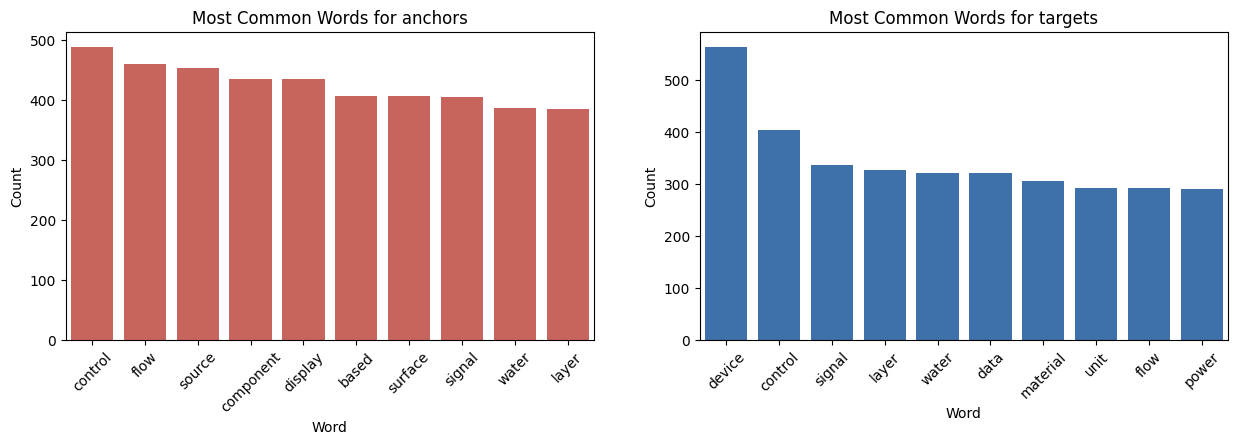

In [ ]:
## Plot most common words
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter

stop = ENGLISH_STOP_WORDS.union(stop) # combine stop words from different sources

# function for removing url from text
def remove_url(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

# Get all the word tokens in dataframe
# - remove url, tokenize tweet into words, lowercase words
corpus0 = []
[corpus0.append(word.lower()) for elem in train.anchor for word in word_tokenize(remove_url(elem))]
corpus0 = list(filter(lambda x: x not in stop, corpus0)) # use filter to unselect stopwords

corpus1 = []
[corpus1.append(word.lower()) for elem in train.target for word in word_tokenize(remove_url(elem))]
corpus1 = list(filter(lambda x: x not in stop, corpus1)) # use filter to unselect stopwords

# Create df for word counts to use sns plots
a = Counter(corpus0).most_common()
df0 = pd.DataFrame(a, columns=['Word','Count'])

a = Counter(corpus1).most_common()
df1 = pd.DataFrame(a, columns=['Word','Count'])

# Plot
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.barplot(x='Word',y='Count',data=df0.head(10), color=color[1]).set_title('Most Common Words for anchors')
plt.xticks(rotation=45)
plt.subplot(1,2,2)
sns.barplot(x='Word',y='Count',data=df1.head(10), color=color[0]).set_title('Most Common Words for targets')
plt.xticks(rotation=45)

## Tokenization

### Finalizing dataframe setup

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.3 MB/s eta 0:00:00


In [ ]:
train.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [ ]:
train = train.drop(columns=['char_len', 'word_len'])

In [ ]:
train['input'] = 'TEXT1: ' + train.context + '; TEXT2: ' + train.target + '; ANC1: ' + train.anchor

In [ ]:
from datasets import Dataset,DatasetDict

train_ds = Dataset.from_pandas(train)

In [ ]:
model_nm = 'microsoft/deberta-v3-small'

In [ ]:
!pip install transformers

In [ ]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.1 MB/s eta 0:00:00


In [ ]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:470: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def tok_func(x): return tokz(x["input"])

In [ ]:
tok_ds = train_ds.map(tok_func, batched=True)

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

In [ ]:
row = tok_ds[0]
row['input'], row['input_ids']

('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  47284,
  2])

In [ ]:
tokz.tokenize(train_ds["input"][0])

['▁TEXT',
 '1',
 ':',
 '▁A',
 '47',
 ';',
 '▁TEXT',
 '2',
 ':',
 '▁abatement',
 '▁of',
 '▁pollution',
 ';',
 '▁ANC',
 '1',
 ':',
 '▁abatement']

In [ ]:
tokz.vocab['▁abatement']

47284

In [ ]:
tok_ds = tok_ds.rename_columns({'target':'labels'})

In [ ]:
tok_ds

Dataset({
    features: ['id', 'anchor', 'labels', 'context', 'score', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})

## Test and validation sets

In [ ]:
eval_df = pd.read_csv('./test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


### Validation set

In [ ]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'labels', 'context', 'score', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'labels', 'context', 'score', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

### Test set

In [ ]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

In [ ]:
eval_ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36
})

### Measure coef

In [ ]:
import numpy as np

In [ ]:
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

## Training

### Training our model

In [ ]:
!pip install transformers[torch]

In [ ]:
from transformers import TrainingArguments,Trainer

In [ ]:
bs = 128
epochs = 4

In [ ]:
lr = 8e-5

In [ ]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=corr_d)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train();

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


ValueError: ignored

In [ ]:
train.dtypes

id          object
anchor      object
target      object
context     object
score      float64
input       object
dtype: object